### The previous notebook introduced the implementation of two classes, the **Lichess** class and the **Wrangle** class. The former class obtains chess game information from Lichess.org for a specified username, producing PGN and two CSV files as well as a DataFrame of the chess games information. The latter class performs data cleaning on the chess game information dataframe to prepare it for subsequent data analysis or time series forecasting.

### In this notebook, the **Lichess** class is used to construct a dataframe of my chess games, which is then cleaned using the Wrangle class for answering important questions through data analysis."

#### Some of the questions I aim to answer through this analysis include:

1.What is the distribution of the number of games played over time? Do I tend to play more or less at certain times?

2.What is the ditribution of my games' results over time? Do I have more wins or losses at certain times?

3.What is the distribution of my rating's difference overtime? Do I tend to gain or lose more points at certain times?

4.How does my ELO rating evolve over time, and are there any patterns or fluctuations in my rating?

5.What is the distribution of my opponents' ELO ratings? Do I tend to play against higher-rated or lower-rated opponents?

6.What are the most common openings that I play? Do I have more success with certain openings?

7.Do I tend to perform better with certain colors of pieces (e.g., white or black)?

8.What is the distribution of game terminations? Do I tend to win more games by checkmate/resignation or by time forfeit?

9.Are there any correlations between the game result and opponent ELO rating or opponent title? 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)
px.defaults.template = "plotly_dark"

from datetime import datetime
from dateutil import tz

from Data import LichessAPI, Wrangle

import pickle
import warnings
warnings.simplefilter('ignore')
pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
#Global variables
USERNAME = 'YoussefAtef91'
TIME_ZONE = 'Egypt/Cairo'

#Colors
purple = '#7D3C98'
green = '#1ABC9C'
blue = '#2980B9'
yellow = '#D4AC0D'
red = '#B03A2E'
white = '#DCDCDC'
black = '#6D6D6D'

In [4]:
# using LichessAPI to get my lichess games as a dataframe
My_Lichess = LichessAPI(username=USERNAME)
df_lichess = My_Lichess.to_dataframe()

INFO:pgn2data - log_time:initializing at...2023-03-03 20:55:03.113420
INFO:pgn2data - pgn_data class:Starting process..
INFO:pgn2data - process:Processing file:2023-03-03T22.38.02-YoussefAtef91.pgn
INFO:pgn2data - pgn_data class:ending process..
INFO:pgn2data - log_time:time taken sec: 778.4511299999999 sec
INFO:pgn2data - log_time:time taken: 12.0 minutes, 58.45112999999992 seconds, 
INFO:pgn2data - log_time:time started...2023-03-03 20:55:03.113420
INFO:pgn2data - log_time:time ended.....2023-03-03 21:08:01.565906


In [3]:
# df_lichess = pd.read_csv("../data/2023-03-04T04.01.34-YoussefAtef91_game_info.csv")

In [4]:
df_lichess.shape

(20346, 29)

In [5]:
# Use the Wrangle class to transform the dataframe for analysis
wrangler = Wrangle(df=df_lichess,username=USERNAME,timezone=TIME_ZONE)
df = wrangler.wrangle()

In [6]:
df.head()

,game_id,site,result,termination,time_control,variant,game_type,chess_type,in_tournament,color,opponent_username,opponent_title,my_elo,opponent_elo,elo_diff,rating_gained,rating_lost,opening,date,year,month,day,day_of_week,hour
0,0,https://lichess.org/cd76rKo8,win,Time forfeit,60+0,Standard,Rated,Bullet,0,black,tarkovsky_06,None,2168,2063,105,5,0,King's Pawn Game,2023-03-03,2023,Mar,03,Friday,07
1,1,https://lichess.org/HHUsKr0u,loss,Normal,60+0,Standard,Rated,Bullet,0,white,panget29,None,2175,2113,62,0,7,Queen's Pawn Game,2023-03-03,2023,Mar,03,Friday,07
2,2,https://lichess.org/qGAj2jXW,draw,Time forfeit,60+0,Standard,Rated,Bullet,0,white,chessbaddie69,None,2175,2199,-24,0,0,Queen's Pawn Game,2023-03-03,2023,Mar,03,Friday,07
3,3,https://lichess.org/V20i7szv,draw,Normal,60+0,Standard,Rated,Bullet,0,white,Feder1020,None,2175,2154,21,0,0,King's Indian,2023-03-03,2023,Mar,03,Friday,07
4,4,https://lichess.org/gcWlPtwe,win,Time forfeit,60+0,Standard,Rated,Bullet,0,black,alidhk,None,2169,2192,-23,6,0,Uncommon Opening,2023-03-03,2023,Mar,03,Friday,07


The following two cells ensures that the Dataframe being used is suitable for this notebook.

In [7]:
int32 = ["game_id","my_elo","opponent_elo","elo_diff"]
int64 = ["in_tournament","rating_gained","rating_lost"]
objects = ["site","result","termination","time_control","variant","game_type","chess_type","color",
           "opponent_username","opponent_title", "opening","year","month","day","day_of_week","hour"]
datetimes = ["date"]

In [8]:
# Does 'wrangle' return a DataFrame?
assert isinstance(df,pd.DataFrame)

# Does the DataFrame have 24 columns
assert df.shape[1] == 24

# Does the DataFrame have correct column names?
cols = (int32 + int64 + objects + datetimes)
cols.sort()
assert all(df.columns.sort_values() == cols)

# Does columns have correct data types?
assert any(df[int32].dtypes == np.int)
assert any(df[int64].dtypes == np.int64)
assert any(df[objects].dtypes == np.object0)
assert any(df[datetimes].dtypes == '<M8[ns]')


## What is the distribution of the number of games played over time? Do I tend to play more or less at certain times?

### Number of Games by Day of Week

In [9]:
pivot_table = pd.pivot_table(df, index='day_of_week',columns = 'result', values = 'game_id', aggfunc='count')

day_order = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
pivot_table = pivot_table.reindex(day_order)
days_of_week = pivot_table.index

fig = px.bar(pivot_table,x=days_of_week, y=['win','loss','draw'],color_discrete_sequence=[blue,purple,green],
             title='Number of Games by Day of Week',barmode ='stack')
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Day of Week',yaxis_title = 'Number of Games')
fig.show()

It seems that there is a correlation between the amount of games that I play and my college class schedule, as I used to have classes on Sunday, Monday, Wednesday, and Thursday. On Friday, when I didn't have any classes I played more than 3,400 games, which is the highest number I played in a single day. On the other hand, on Sunday When I had a class, I played only about 2,500 games, which is the lowest number of games played in a single day.

And since I am a Premier League fan (which is usually played on Saturday and Sunday), the least two days in terms of the amount of games played are Saturday and Sunday on which Premier League matches are played and I have classes.

**Conclusion**: This chart shows that my availability to play chess is influenced by my class schedule and Premier League matches. Other factors should also be considered that may also be impacting the number of games I play, such as my level of motivation, time available outside of classes, and level of fatigue.

In [10]:
fig.write_image("../figures/Number of games by day of week.png")

### Number of games by hours

In [11]:
pivot_table = pd.pivot_table(df, index='hour',columns = 'result', values = 'game_id', aggfunc='count')
Hour = pivot_table.index

fig = px.bar(pivot_table,x=Hour, y=['win','loss','draw'], color_discrete_sequence=[blue,purple,green],
             title='Number of Games by Hour',barmode ='stack')
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Hour',yaxis_title = 'Number of Games')
fig.update_xaxes(tickangle=0,dtick='3')
fig.show()

By dividing this chart into two time periods, from 2 am to 3 pm and from 4 pm to 1 am, it becomes evident that the first period has a lower average number of games played per hour, ranging from less than 500 to less than 1000. This can be attributed to the corresponding time frames coinciding with the my sleeping and college class schedule (particularly from 7 am to 1 pm). Conversely, the second period reveals a higher average number of games played, exceeding 1000 games for each hour, as it encompasses my leisure time after college or before sleep.

**Conclusion**: The average number of games played per hour appears to be influenced by my schedule, with lower average games played during sleeping time and class hours and higher average games played during leisure time.

In [12]:
fig.write_image("../figures/Number of games by hours.png")

## What is the ditribution of my games' results over time? Do I have more wins or losses at certain times?

### Winning Percentage by Day of Week

In [13]:
pivot_table = pd.pivot_table(df, index='day_of_week',columns = 'result', values = 'game_id', aggfunc='count')
day_order = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
pivot_table = pivot_table.reindex(day_order)

pivot_table['total'] = pivot_table['win'] + pivot_table['loss'] + pivot_table['draw']
pivot_table['winning_pct'] = pivot_table['win'] * 100 / pivot_table['total']

days_of_week = pivot_table.index

fig = px.bar(pivot_table,x=days_of_week, y='winning_pct',color_discrete_sequence=[blue,purple,green],
             title='Winning Percentage by Day of Week',barmode ='stack')
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Day of Week',yaxis_title = 'Winning PCT', yaxis=dict(range=[45,55]))
fig.show()

It seems like every day has a winning rate of over 50%. Nonetheless, some days are worse than others. As we already observed earlier, the least number of games were played on Saturday, Sunday, and Wednesday, while the most games were played on Friday. Yet, Saturday, Sunday, and Wednesday have a higher winning rate than Friday. 

**Conclusion:** There might be a correlation between the number of games played and the winning percentages as I tend to have a better winning percentage on the days I don't play much on

In [14]:
fig.write_image("../figures/winning pct by day of week.png")

### Winning Percentage by Hours

In [15]:
pivot_table = pd.pivot_table(df, index='hour',columns = 'result', values = 'game_id', aggfunc='count')
Hour = pivot_table.index
pivot_table['total'] = pivot_table['win'] + pivot_table['loss'] + pivot_table['draw']
pivot_table['winning_pct'] = pivot_table['win'] * 100 / pivot_table['total']

fig = px.bar(pivot_table,x=Hour, y="winning_pct", color_discrete_sequence=[blue,purple,green],
             title='Winning Percentage by Hour',barmode ='stack')
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Hour',yaxis_title = 'Winning PCT', yaxis=dict(range=[45,55]))
fig.update_xaxes(tickangle=0,dtick='3')
fig.show()

**Conclusion**: It doesn't seem to be any meaningful pattern here. Although all hours have a winning rate of over 50%, only 10 am has a much lower winning rate (49.34%) which is interesting but it's probably due to chance.

In [16]:
fig.write_image("../figures/winning pct by hours.png")

## What is the distribution of my rating's difference overtime? Do I tend to gain or lose more points at certain times?

### Average Rating Difference by Month

In [17]:
mask_standard = df['variant'] == 'Standard'
mask_rated = df['game_type'] == 'Rated'
mask_bullet = df['chess_type'] == 'Bullet'
mask_blitz = df['chess_type'] == 'Blitz'
mask_rapid = df['chess_type'] == 'Rapid'

df_standard_rated = df[mask_standard & mask_rated]
df_bbr = df_standard_rated[mask_bullet | mask_blitz | mask_rapid]
pivot_table = pd.pivot_table(df_bbr, index='month', values = ['rating_gained','rating_lost'], aggfunc='mean')
pivot_table['rating_diff'] = pivot_table['rating_gained'] - pivot_table['rating_lost']

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pivot_table = pivot_table.reindex(months)

months = pivot_table.index

fig = px.bar(pivot_table,x=months,y='rating_diff',color_discrete_sequence=[blue],
             title="Average Ratings Difference by Month" ,barmode ='group')
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Month',yaxis_title = 'Rating Diff')
fig.show()

**Conclusion**: With the exception of March and May, the difference between the winning % and the losing percentage is always positive. Even though May's rating difference is considerably less than that of other months, it doesn't seem out of the ordinary given that the y-range axis's is between -0.6 and 0.6, which is so small given that I gain or lose, on average, roughly 6/7 points.

In [18]:
fig.write_image("../figures/avg rating diff by month.png")

### Average Rating Difference by Day of Week

In [19]:
mask_standard = df['variant'] == 'Standard'
mask_rated = df['game_type'] == 'Rated'
mask_bullet = df['chess_type'] == 'Bullet'
mask_blitz = df['chess_type'] == 'Blitz'
mask_rapid = df['chess_type'] == 'Rapid'

df_standard_rated = df[mask_standard & mask_rated]
df_bbr = df_standard_rated[mask_bullet | mask_blitz | mask_rapid]

pivot_table = pd.pivot_table(df_bbr, index='day_of_week', values = ['rating_gained','rating_lost'], aggfunc='mean')

day_order = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
pivot_table = pivot_table.reindex(day_order)
pivot_table['rating_diff'] = pivot_table['rating_gained'] - pivot_table['rating_lost']
days_of_week = pivot_table.index

fig = px.bar(pivot_table,x=days_of_week,y='rating_diff',color_discrete_sequence=[blue],
             title="Average Ratings Difference by Day of Week" ,barmode ='group')
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Day of Week',yaxis_title = 'Number of Games')
fig.show()

**Conclusion**:  It looks like my average rating difference varies depending on the day of the week. Sunday, Tuesday, and Friday seem to be the days when I perform better, as they have higher average rating differences. However, again, it's worth noting that the differences are relatively small (ranging from -0.14 to 0.36) compared to the 6 or 7 points that I typically gain or lose per game. 

In [20]:
fig.write_image("../figures/avg rating diff by day of week.png")

### Average Rating Difference by Hour

In [21]:
mask_standard = df['variant'] == 'Standard'
mask_rated = df['game_type'] == 'Rated'
mask_bullet = df['chess_type'] == 'Bullet'
mask_blitz = df['chess_type'] == 'Blitz'
mask_rapid = df['chess_type'] == 'Rapid'

df_standard_rated = df[mask_standard & mask_rated]
df_bbr = df_standard_rated[mask_bullet | mask_blitz | mask_rapid]

pivot_table = pd.pivot_table(df_bbr, index='hour', values = ['rating_gained','rating_lost'], aggfunc='mean')
pivot_table['rating_diff'] = pivot_table['rating_gained'] - pivot_table['rating_lost']
hours = pivot_table.index
fig = px.bar(pivot_table,x=hours,y='rating_diff',color_discrete_sequence=[blue],
             title="Average Ratings Difference by Hours" ,barmode ='group')
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Hours',yaxis_title = 'Number of Games')
fig.show()

This chart seems like it could be divided into 4 clusters, with the first cluster covering the hours of 12 am to 5 pm ("Late Night"), the second cluster covering the hours of 6 am to 11 am ("Early Morning"), the third cluster covering the hours of 12 pm to 5 pm ("Afternoon"), and the last cluster covering the hours of 6 pm to 11 pm ("Early Night"). In the Late Night cluster, it appears that I tend to perform worse and that's logical since I should sleep at that time. The Early Morning cluster, features my best two hours (7 and 9 am) in terms of performance while the other hours are close to 0, which is interesting considering lectures often start at 8 and 10 am and I usually play before lectures, It's also early in the morning, which helps my focus. In the Afternoon and Early Night clusters, Even while there are positives in both clusters, the Afternoon cluster appears to be much better than the Early Night Cluster.
Conclusion: I perform better in the morning and afternoon when I play, but I lose points when I play after midnight.

In [22]:
fig.write_image("../figures/avg rating diff by hour.png")

## How does my ELO rating evolve over time, and are there any patterns or fluctuations in my rating?

In [23]:
Standard_df = df[df['variant']=='Standard']
Games_per_Month = Standard_df[['my_elo','date','chess_type']]
pivot_table = pd.pivot_table(Games_per_Month,index='date',columns='chess_type',values='my_elo',aggfunc='last')
pivot_table.fillna(method='ffill', inplace=True)
Date = pivot_table.index

fig = px.line(pivot_table,x=Date,y=['Blitz','Bullet','Classical','Rapid','UltraBullet'],title='My Elo over Time',
             color_discrete_sequence=[blue,purple,green,yellow,red])
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Date',yaxis_title = 'Elo')
fig.show()

The lines of Ultrabullet and Classical looks so smooths indicating that I don't play these types so much. It also shows that I jumped from 1100 elo rating in rapid to 2000 in one and a half years (may 2020 - jan 2022) which is pretty good. But what's more intersting is that I jumped from 1300 elo in bullet to 2000 in less than one year (jul 2020 - jun 2021), even though I only increased 200 elo ratings in one and a half year (jun 2021 - dec 2022)

**Conclusion**:There a huge growth in my first year of playing chess or until I reached 2000 elo on the contrary of after that, this could be bacause of my excitement of the game in the first years, ease of the oppoenents, or maybe beacuse I have achieved my goal of eaching 2000 elo and didn't set another goal of eaching higher elo ratings.

In [24]:
fig.write_image("../figures/elo over time.png")

## What is the distribution of my opponents' ELO ratings? Do I tend to play against higher-rated or lower-rated opponents?

In [25]:
fig = px.histogram(df['elo_diff'], title='The Distribution of the Elo Difference Between Me and My Opponents',
                  color_discrete_sequence=[blue])
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Elo Diff',yaxis_title = 'Frequency')
fig.show()

In [26]:
fig.write_image("../figures/opponents elo distribution.png")

Lets create a QQ-Plot to see how that distribution is different from the normal distribution.

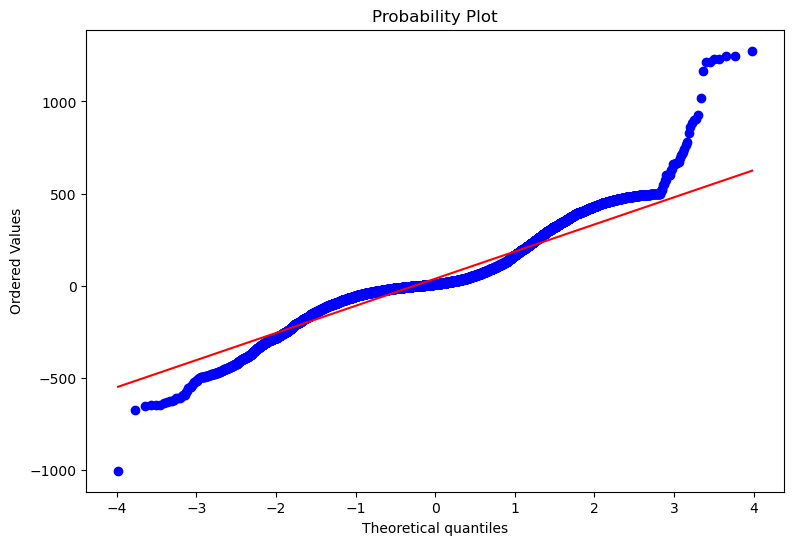

In [27]:
fig, ax = plt.subplots(figsize=(9,6))
stats.probplot(df['elo_diff'],plot=ax)
plt.show()

The data appears to follow a normal distribution with a small standard deviation. It's also slightly right-skewed, with long tails.

The reason for the normal distribution is that the chess game system in Lichess only allows you to play against players who have a rating of 500 higher or lower than you. You can also choose the range of players you want to play against, but neither more nor less than 500 ratings, and I typically set it to the range from 0 to 500+ when I play unrated games so I can practice against higher-rated players. The right skewness of the histogram may therefore be due to this. The long tails could be due to tournaments, where you can play any player with any rating differential, even if it's more than 1000 ratings.

**Conclusion**: The majority of players I've played against appear to have similar ratings to mine, but I've also faced a handful who have much more or less ratings than me, which could be due to tournaments or how I set the rating range for the opponents I face.

## What are the most common openings that I play? Do I have more success with certain openings?

In [28]:
pivot_table = pd.pivot_table(df, index='opening', columns='result', values='game_id', aggfunc='count')
pivot_table['Total'] = pivot_table['win'] + pivot_table['loss'] + pivot_table['draw']
pivot_table['winning_percentage'] = pivot_table['win'] / pivot_table['Total']
pivot_table = pivot_table.sort_values(by='winning_percentage', ascending=False)

top_openings = pivot_table.sort_values(by = "Total",ascending=False).iloc[:20]
openings = top_openings.index
winning_percentages = top_openings['winning_percentage']
total = top_openings['Total']
percentage = round(top_openings['winning_percentage'] * 100,2).astype(str) + str("%")

fig = px.bar(x=openings,y=total,color=winning_percentages,range_x=[-1,20.5], range_y=[0,1500],
            text=percentage, title='Winning Percentage by Opening (Top 20)',)
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = '',yaxis_title = 'Number of Games')
fig.show()

**Conclusion**: I've played the "Queen's Pawn Game" opening ten times more than the next-closest opening. It shows that I don't like playing different openings, which is correct. But there are some openings that I have to face, some of which I can handle and some I cannot. Now, let's look at the top 20 openings that I play (or play against) to see which ones I have to study more.
King's Gambit Declined (with 42.39% winning rate), Nimzovich-Larsen Attack (45.42%), Queen's Gambit Decline (46.33%), and Scotch Game (46.48%). These openings have the least winning percentages in my top 20 played openings.

In [29]:
fig.write_image("../figures/top openings.png")

## Do I tend to perform better with certain colors of pieces (e.g., white or black)?

In [30]:
pivot_table = pd.pivot_table(df, columns='color', index='result', values="game_id", aggfunc="count")

fig = px.bar(pivot_table,barmode='group', title="Games' Results for each Piece Color", color_discrete_sequence=[blue,white])
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Results',yaxis_title = 'Number of Games')
fig.show()

Although it may appear natural that any chess player's score with white pieces should be higher than with black pieces due to the advantage of making the first move and choosing the opening, some players actually prefer to play with black since it may be easier to react to an opponent's move.

**Conclusion**: Nonetheless, It appears that I perform better with white than with black.

In [31]:
fig.write_image("../figures/black vs white.png")

## What is the distribution of game terminations? Do I tend to win more games by checkmate/resignation or by time forfeit?

In [33]:
rated = df['game_type'] == 'Rated'
bullet = df['chess_type'] == 'Bullet'
df_wrb = df[rated & bullet]
pivot_table = pd.pivot_table(df_wrb,columns='result',index='termination',values='game_id',aggfunc='count')

fig = px.bar(pivot_table,barmode='group',title="Games' Results for each Game's Termination",
            color_discrete_sequence=[green,purple,blue])
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Results',yaxis_title = 'Number of Games')
fig.show()

This chart shows that I win with time forfeit more that I get flagged, while I get checkmated more than I win with checkmate. This shows that I rely on my speed in bullet games rather than checkmating.

**Conclusion**: If I won a game, it was probably because I flagged my opponents rather than checkmating them. And if I lose a game, it'll be due to being checkmated rather than being flagged.

Flagging in chess refers to the act of winning (or drawing) a game on time.

In [34]:
fig.write_image("../figures/game termination.png")

## Are there any correlations between the game result and opponent ELO rating or opponent title?

In [36]:
df_win_loss = df[df['result'] != 'draw']

fig = px.histogram(df_win_loss['elo_diff'],color=df_win_loss['result'],barmode='overlay', title="Elo Difference Histogram",
                  color_discrete_sequence=[blue,red])
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Elo Diff',yaxis_title = 'Frequency')
fig.show()

Surprisingly, I win more against higher-rated opponents. Maybe it's because higher-rated players feel more pressure when they play against lower-rated players, or because I pay more attention when I play against higher-rated opponents.

Lets see how I perform against titled players.

In [37]:
fig.write_image("../figures/result vs opponent elo distribution.png")

In [38]:
df_title = df[df['opponent_title'] != "None"]

fig = px.bar(df_title['result'].value_counts(), title="Games' Results Against Titled Players", color_discrete_sequence=[blue])
fig.update_layout(font_color = '#AEB6BF',title_x = 0.5,title_font_size = 20,
                  xaxis_title = 'Results',yaxis_title = 'Number of Games')
fig.show()

Wow! I played against 24 titled players and won 15 games and drew once.

**Conclusion**: I tend to perform better against higher rated players.

In [39]:
fig.write_image("../figures/result vs titled players.png")

<center style="font-size:25px;"><br><br>🤍 🤍 Thank you for reading this notebook 🤍 🤍<br><br></center>